# Advanced Statistical Inference -- Gaussian Process for Regression

Today, we will play with Gaussian processes. By the end of this lab, you will be able to 
 
- To sample from a Gaussian process prior distribution.
- To implement Gaussian process inference for regression.
- To use the above to observe samples from a Gaussian process posterior distribution.
- To evaluate how different hyperparameter settings impact model quality.
- To investigate different kernel functions and parameter optimisation strategies.

Gaussian processes (henceforth GPs) achieve greater flexibility over parametric models by imposing a preference bias as opposed to restrictive constraints. Although the parameterisation of GPs allows one to access a certain (infinite) set of functions, preference can be expressed using a prior over functions. This allows greater freedom in representing data dependencies, thus enabling the construction of better-suited models. In this lab, we shall cover the basic concepts of GP regression. For the sake of clarity, we shall focus on univariate data, which allows for better visualisation of the GP model. Nonetheless, the code implemented within this lab can be very easily extended to handle
multi-dimensional inputs.


In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy as scipy
import scipy.spatial as ss
from scipy.stats import multivariate_normal

import math


import matplotlib 
import matplotlib.font_manager
import matplotlib.pyplot as plt
#matplotlib.rc_file('~/.config/matplotlib/matplotlibrc')
import warnings


warnings.filterwarnings("ignore")
def set_seed(seed: int=0):
    np.random.seed(seed)


# 1. Sampling from the GP Prior

We shall consider a one-dimensional regression problem, whereby the inputs x are transformed by
a function $f(x) = 2sin(exp(0.03 * x))$. 

**Exercise:**
Generate 200 random points, $x$, in the range $[-20, 80]$, and compute their corresponding function
values, $\mathbf{f}$. The target function can then be plotted accordingly.


[ 1.99107736  1.41595155 -1.99784443  1.31715029 -1.76032599  1.19058263
 -0.80149384 -1.13230168  1.5502595   1.07171904 -1.58832638 -1.99113063
  1.22156238  1.8350681   1.26067758  1.68294197  1.61719509  1.02444948
  1.38273417  1.91094042  1.93235157  1.48295569  1.26067758 -1.7630695
  1.8493126   1.8493126   0.43147508 -0.68936859  1.63787562  1.44937977
  1.31715029  1.25300362 -0.94335794 -0.55201331  1.74650369  0.21405772
  1.07171904  1.0433475  -0.35515498 -0.09855736  1.28487741  1.97336876
  1.44937977  1.55877128 -1.99784443  1.95138485 -1.99113063  1.13010285
 -1.94701319  1.71506581  1.3701138   0.21405772  1.13010285 -1.7630695
  1.80668273  1.82378943 -1.58832638  1.86205434  1.01088752 -0.46284154
  1.90660115  0.28017832  1.51660857 -1.13230168 -1.7630695   1.8350681
 -1.63431075  1.8493126   1.25300362  1.86205434  1.8350681   1.74650369
  1.31715029 -1.63189099  1.77709946  1.88742354  1.99107736  0.21405772
  0.65977306  1.97895093  1.28487741  1.98113259  1.99

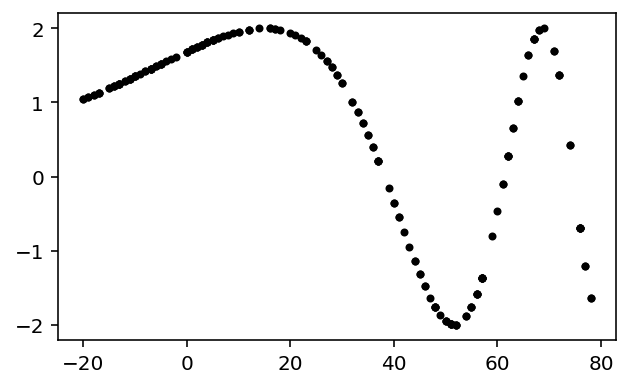

[[1]
 [5]]
[[0. 4.]
 [4. 0.]]


In [50]:
set_seed(1)

def f(x):
    return 2*np.sin(np.exp(0.03*x))

X = np.random.randint(-20,80,size=200)## *** TO COMPLETE *** ##
y = f(X)
print(y)
fig, ax = plt.subplots(figsize=[5,3])
ax.plot(X, y, '.k')
plt.show()

X = np.array(X).reshape(-1,1)

a = [1,5]
a = np.array(a)
a=a.reshape(-1,1)
print(a)
print(ss.distance.cdist(a,a))


Recall that since GPs are non-parametric; we define a prior distribution over functions (models),
specified as a multivariate Gaussian distribution $p(f) = \mathcal{N} (\mu, \Sigma)$.

Without loss of generality, we shall assume a zero-mean GP prior, i.e. $\mu = 0$. The covariance
matrix of the distribution, $\Sigma$, may then be computed by evaluating the covariance between the
input points. For this tutorial, we shall consider the widely used squared-exponential (RBF)
covariance (also referred to as the kernel function), which is defined between two points as: 

$$k(x, x') = \sigma_\mathrm{f}^2 \exp \Big( -\dfrac {(x-x')^2}{2l^2} \Big). $$

This kernel is parameterised by a lengthscale parameter $l$, and variance $\sigma_\mathrm{f}^2$ . Given that the true
function may be assumed to be corrupted with noise, we can also add a noise parameter, $\sigma_\mathrm{n}^2$ , to
the diagonal entries of the resulting kernel matrix, $K$, such that

$$K_y = K + \sigma_\mathrm{n}^2I.$$


**Exercise:**
Complete the `compute_kernel()` function for computing the RBF kernel $K$ between two sets of input points.
Hint: The `cdist` function in scipy can be used for evaluating the pairwise Euclidean distance between two sets of points.



In [43]:
class Kernel:
    def compute_squared_distance(self, X, Z):
        return ss.distance.cdist(X,Z)
    
    def __call__(self, X, Z=None):
        Z = X if Z is None else Z  # Just a simple trick
        return self.compute_kernel(X, Z)
    

class RBF(Kernel):
    def __init__(self, lengthscale, variance):
        self.lengthscale = lengthscale
        self.variance = variance
    
    def compute_kernel(self, X, Z):
        sq_dists = Kernel.compute_squared_distance(self, X, Z)
        print(sq_dists)
        print(self.variance, self.lengthscale)
        return self.variance*np.exp(-(sq_dists**2)/(2*self.lengthscale**2))

**Exercise:** Compute the kernel matrix $K(\mathbf{X}, \mathbf{X})$. Plot it using `plt.matshow()`. Start with $\sigma^2_\mathrm{f}$ and $l$ both equal to one. Then try to change this two parameter. What do you see? Comment the figure.

[[0.         0.57512581 3.98892179 ... 0.62096357 0.43230608 3.36052376]
 [0.57512581 0.         3.41379598 ... 0.04583775 0.14281973 2.78539795]
 [3.98892179 3.41379598 0.         ... 3.36795823 3.55661571 0.62839803]
 ...
 [0.62096357 0.04583775 3.36795823 ... 0.         0.18865749 2.73956019]
 [0.43230608 0.14281973 3.55661571 ... 0.18865749 0.         2.92821768]
 [3.36052376 2.78539795 0.62839803 ... 2.73956019 2.92821768 0.        ]]
0.1 10
(200, 200)
[[0.1        0.09983475 0.09235249 ... 0.09980739 0.0999066  0.0945099 ]
 [0.09983475 0.1        0.09433952 ... 0.09999895 0.0999898  0.09619506]
 [0.09235249 0.09433952 0.1        ... 0.09448626 0.0938711  0.09980275]
 ...
 [0.09980739 0.09999895 0.09448626 ... 0.1        0.09998221 0.09631694]
 [0.0999066  0.0999898  0.0938711  ... 0.09998221 0.1        0.09580337]
 [0.0945099  0.09619506 0.09980275 ... 0.09631694 0.09580337 0.1       ]]


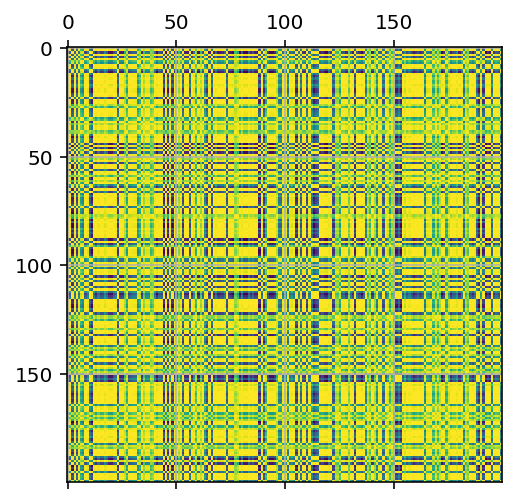

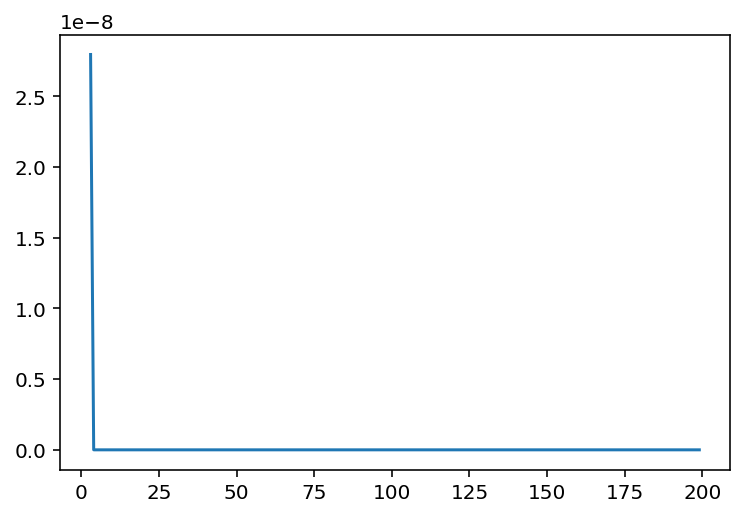

In [48]:
#https://stackoverflow.com/questions/23581508/why-gaussian-radial-basis-function-maps-the-examples-into-an-infinite-dimensiona
#increasing the lengthscale = greater variance
#the "variance" is the amplitude (normalization constant?)

y = np.array(y).reshape(-1,1)

kernel = Kernel()
Kxx = RBF(10, .1).compute_kernel(y,y)
print(Kxx.shape)
print(Kxx)
fig, ax = plt.subplots()
ax.matshow(Kxx) ## *** TO COMPLETE *** ##
ax.grid(None)
plt.show()

det=[]
abss=[]
for k in range(3,X.shape[0]):
    det.append(np.linalg.det(Kxx[:k,:k]))
    abss.append(k)
plt.plot(abss,det)
plt.show()

    

Now you are ready to sample from the GP prior. Remember if $\mathbf{f}$ follows a GP, ie $\mathbf{f} \sim \mathcal{GP}(\mu, \mathbf{\Sigma})$, then $p(\mathbf{f}) = \mathcal{N}(\mu, \mathbf{\Sigma})$.

**Exercise:**
Assuming a zero-mean prior, and using the RBF kernel constructed before, we can sample from the prior distribution using the numpy `multivariate_normal()` function.
For the time being, you can initialise the kernel parameters as follows:

- lengthscale = 10
- variance = 0.1

You can use the following helper function to plot the GP.

In [25]:
def plot_gp(x, mean, cov, palette="Greens", fill_alpha=0.95, ax=None, fill_kwargs={},):
    """ A helper function for plotting 1D GP from mean and cov """
    
    if ax is None:
        ax = plt.gca()
        
    cmap = plt.get_cmap(palette)
    ci = np.linspace(0.5, 3, 50)

    colors = (ci - np.min(ci)) / (np.max(ci) - np.min(ci) + 3)+.1
    
    x = x.flatten()

    ax.plot(x, mean, color=cmap(0.9))
    for i, c in enumerate(ci[::-1]):
        upper = mean + c * np.diag(cov)
        lower = mean - c * np.diag(cov)
        color_val = colors[i]
        ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=fill_alpha, **fill_kwargs)

    return ax

def plot_gp_from_samples(x, samples, palette="Greens",ax=None, alpha=0.75, **kwargs):
    """ A helper function for plotting 1D GP samples """
    
    if ax is None:
        ax = plt.gca()
        
    cmap = plt.get_cmap(palette)
    ci = np.linspace(0.5, 5, 50)

    colors = (ci - np.min(ci)) / (np.max(ci) - np.min(ci) + 3)#+.1

    #samples = samples.T
    print(samples.shape)
        
    idx = np.random.randint(0, samples.shape[0], 20)
    print(idx)
    print(samples[idx])
    #ix instead o 0 samples[:,0]
    ax.plot(x, samples, color=cmap(0.5), lw=1, alpha=alpha, **kwargs)
    
    return ax

[[ 0. 25. 35. ... 12. 10. 40.]
 [25.  0. 60. ... 37. 35. 65.]
 [35. 60.  0. ... 23. 25.  5.]
 ...
 [12. 37. 23. ...  0.  2. 28.]
 [10. 35. 25. ...  2.  0. 30.]
 [40. 65.  5. ... 28. 30.  0.]]
0.1 10
(200,)
[172  47 117 192  67 195 103   9  21  36  87  70  88 140  58 193  39  87
 174  88]
[0.00000000e+000 0.00000000e+000 1.22937835e+024 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 2.39932705e-282 2.39932705e-282
 0.00000000e+000 2.72611424e-172 0.00000000e+000 7.26610581e+011
 0.00000000e+000 2.39932705e-282 0.00000000e+000 0.00000000e+000]


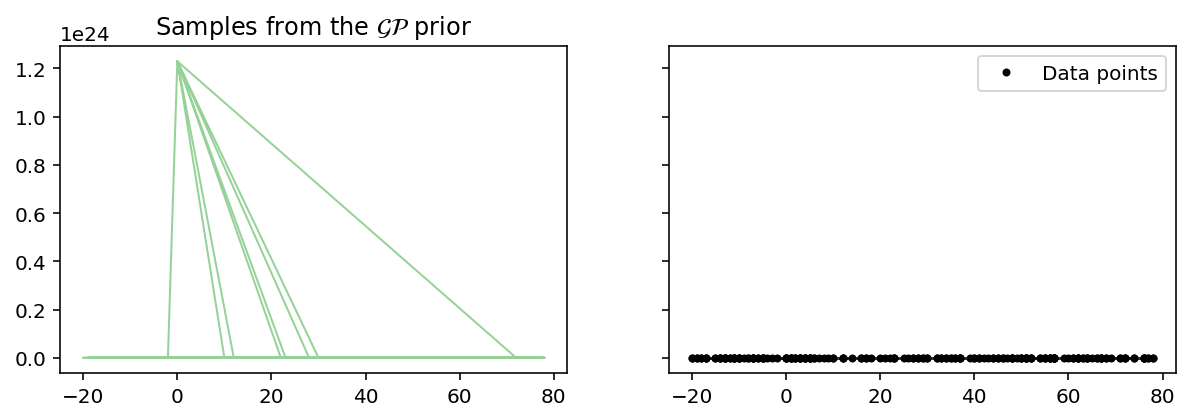

In [45]:
set_seed()

kernel = RBF(10, .1)

mean = np.zeros(X.shape[0]) ## *** TO COMPLETE *** ##
cov = kernel.compute_kernel(X,X) ## *** TO COMPLETE *** ##
samples =multivariate_normal.pdf(X, mean=mean, cov=cov, allow_singular=True)## *** TO COMPLETE *** ##


fig, axs = plt.subplots(1, 2, figsize=[10, 3], sharey=True)

plot_gp_from_samples(X, samples, ax=axs[0])
plot_gp(X, mean, cov, ax=axs[1])

axs[1].plot(X, y, '.k', label='Data points')
axs[0].set_title(r'Samples from the $\mathcal{GP}$ prior')
axs[1].legend()
plt.show()

**Exercise:** Try to change the kernel hyperparameters and plot few samples from their corresponding $\mathcal{GP}$ prior. What do you observe?

# 2. Inference with GP


Recall that the prior represents our prior beliefs before observing the function values of any data points. Suppose we can now observe 3 points at random from the input data; we would expect that with this additional knowledge, the functions drawn from the updated GP distribution would be constrained to pass through these points (or at least close if corrupted with noise). The combination of the prior and the likelihood of the observed data leads to the posterior distribution over functions.

We will wrap everything in a class, thus to make everything easier to follow. 

**Exercise:** Assign 3 points at random from $\mathbf{X}$ (and their corresponding function values) to `Xtrain` and `ytrain`
respectively. For now we shall assume that all other $\mathbf{X}$ values are unobserved. 

In [ ]:
set_seed()

idx = ## *** TO COMPLETE *** ##
Xtrain = X[idx]
ytrain = y[idx]


The next cell has a skeleton for the GP model. Onward on the notebook, you will be required to go back here and implement the different functions now blank. 

In [75]:
class GPR():
    "Class to implement a Gaussian process model for regression"
    def __init__(self, X, y, kern):
        self.X = X
        self.y = y
        self.kern = kern
        self.likelihood_variance = 1e-3
    
    def sample_f_prior(self, Xtest, nsamples=1):
        raise NotImplementedError('Implement this function to sample from the GP prior.') # Remove this line when done
            
    def predict_f_posterior(self, Xtest):
        raise NotImplementedError('Implement this function to predict mean and var of the GP posterior') # Remove this line when done
    
    def predict_log_likelihood(self):
        raise NotImplementedError('Implement this function to compute the log likelihood') # Remove this line when done


**Exercise:** Complete the function `sample_f_prior` in the class above. Create a new GP model and verify you get the same results as above when you use `sample_f_prior`.

In [76]:
kernel = ## *** TO COMPLETE *** ##
model = ## *** TO COMPLETE *** ##

During the lecture, you have derived the posterior distribution of the GP given data $\{\mathbf{X},\mathbf{y}\}$ (check the lecture note if you don't remeber).

**Note**: As we have encountered in previous labs, matrix inversions can be both numerically troublesome and slow to compute. In this lab, we shall avoid computing matrix inversions directly by instead considering Cholesky decompositions for solving linear systems. You are encouraged to read more about Cholesky decompositions for GPs by consulting Appendix A.4 of [Gaussian Processes for Machine Learning (Rasmussen and Williams, 2005)](http://www.gaussianprocess.org/gpml/) - available online!
The complete pseudo-code for the posterior inference procedure is provided in Algorithm 2.1 from Chapter 2 of this same book.
Unfortunately, that Algorithm explains how to compute the posterior one test point at a time. You could loop through all test points but this is not very efficient. Instead you can compute the posterior for all points in one shot, by remembering that


\begin{align}
p(\mathbf{f_\star}\,|\,\mathbf{y}) &= \mathcal{N}(\mathbf{f}_{\text{mean}}, \mathbf{f}_{\text{cov}}) \\
\mathbf{f}_{\text{mean}} &=  \kappa(\mathbf{X}_\star, \mathbf{X})\left[\kappa(\mathbf{X}, \mathbf{X}) + \sigma_\mathrm{n}^2 I\right]^{-1}\mathbf{y}\\
\mathbf{f}_{\text{cov}} &=  \kappa(\mathbf{X}_\star, \mathbf{X}_star) - \kappa(\mathbf{X}_\star, \mathbf{X})\left[\kappa(\mathbf{X}, \mathbf{X}) + \sigma_\mathrm{n}^2 I\right]^{-1}\kappa(\mathbf{X}_\star, \mathbf{X})^\top
\end{align}



**Exercise:** 
In the class GP, complete the function to compute the posterior GP (`predict_f_posterior`).

**Exercise:** 
Run the previously completed function to compute the GP posterior.

In [77]:
f_mean, f_cov = ## *** TO COMPLETE *** ##

**Exercise:**
Sample few times from the posterior and, using the helper functions defined above, plot the samples and their distribution. Note that we should also add the noise variance to the predictive covariance of the posterior. Fix this accordingly.

In [ ]:
set_seed()

samples = ## *** TO COMPLETE *** ##

fig, axs = plt.subplots(1, 2, figsize=[10, 3], sharey=True)

plot_gp_from_samples ## *** TO COMPLETE *** ##
plot_gp ## *** TO COMPLETE *** ##

axs[0].plot(Xtrain, ytrain, 'Xk',)
axs[1].plot(Xtrain, ytrain, 'Xk', label='Data points')
axs[0].set_title(r'Samples from the $\mathcal{GP}$ post.')
axs[1].legend()

plt.show()

**Exercise:**
As a measure of model quality, you should also compute the log marginal likelihood of the model.
To this end, complete the code provided above to include the negative log likelihood term.

In [ ]:
model.predict_log_likelihood()

**Exercise:**
Try to add more samples, let's say 5, 10 and 20.

In [ ]:
## *** TO COMPLETE *** ##

**Exercise:**
Try to change the kernel parameters (lengthscale and variance). Plot the posterior for 3/4 combinations. 

In [ ]:
## *** TO COMPLETE *** ##

# 3. Model evaluation

**Exercise:**
Run a grid search over a range of parameter values in order to determine which configuration yields the best result (based on the marginal).
Pick 20 samples and run a grid search with $\sigma_\mathrm{f}\in[0.5, 5]$ and $l\in[6, 12]$. *Hint:* To speed up this evaluation, note that you don't need to compute the predictive posterior, you just need the marginal likelihood.

In [ ]:
set_seed()
idx = ## *** TO COMPLETE *** ##
Xtrain = X[idx]
ytrain = y[idx]

In [ ]:
lenghtscales = np.linspace(6, 12, 100)
variances = np.linspace(.5, 5, 100)
marginal_ll = []

for l in lenghtscales:
    for v in variances:
        ## *** TO COMPLETE *** ##

marginal_ll = np.array(marginal_ll).reshape(len(lenghtscales), len(variances))

fig = plt.figure(figsize=(7,5))
ax = fig.gca()
cset = ax.contourf(variances, lenghtscales, marginal_ll, cmap='coolwarm',)
fig.colorbar(cset)
cset = ax.contour(variances, lenghtscales, marginal_ll, colors='k',)
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('Variance')
ax.set_ylabel('Lenghtscale')
plt.show()

## (+) Alternative Kernel Functions
So far we have focused exclusively on the RBF kernel.
However, the choice of kernel function (along with its associated parameters) can have a significant effect on the overall Gaussian process model.
Choosing the best kernel to fit your data is no simple task, and is a pertinent problem in many applied domains.<br>

A brief discussion on this problem may be found here: <a target="_blank" href="https://www.cs.toronto.edu/~duvenaud/cookbook/">Kernel Cookbook</a>. 

Familiarise yourself better with these issues by implementing one or two additional kernels. 

For example, another popular kernel used in GP literature is the **Matérn kernel**.
The Matérn covariance between two points separated by $d=||\mathbf{x}-\mathbf{z}||_2^2$ distance units is given by [Rasmussen & Williams](http://www.gaussianprocess.org/gpml/chapters/RW4.pdf) (Ch. 4).

\begin{align}
C_\nu(d) = \sigma^2\frac{2^{1-\nu}}{\Gamma(\nu)}\Bigg(\sqrt{2\nu}\frac{d}{\rho}\Bigg)^\nu K_\nu\Bigg(\sqrt{2\nu}\frac{d}{\rho}\Bigg),
\end{align}

where $\Gamma$ is the Gamma function, $K_\nu$ is the modified Bessel function of the second kind, and $\rho$ and $\nu$ are non-negative parameters of the covariance.

In practice:

- for $\nu = 1/2$:    $\qquad C_{1/2}(d) = \sigma^2\exp\left(-\frac{d}{\rho}\right)$,

- for $\nu = 3/2$:    $\qquad C_{3/2}(d) = \sigma^2\left(1+\frac{\sqrt{3}d}{\rho}\right)\exp\left(-\frac{\sqrt{3}d}{\rho}\right)$,

- for $\nu = 5/2$:    $\qquad C_{5/2}(d) = \sigma^2\left(1+\frac{\sqrt{5}d}{\rho}+\frac{5d^2}{3\rho^2}\right)\exp\left(-\frac{\sqrt{5}d}{\rho}\right)$.

**Exercise:**
Pick one/two versions of the Matérn kernel and implement them. Plot the prior from the GP with this new kernel. Run the inference task and report/plot the results. *Hint:* You can reuse the code for the RBF kernel to compute the distances and you don't need to change the inference function.


In [ ]:
class Matern32(Kernel):
    def __init__(self, rho, variance):
        ## *** TO COMPLETE *** ##
        
    def compute_kernel(self, X, Z):
        ## *** TO COMPLETE *** ##

# 4. Parameter Optimisation using Gradient Descent

Optimise the hyperparameters of the model by minimising the negative log-likelihood of the model. For a complete solution, you should include the derivatives of the objective function with respect to the parameters being optimised.

The general formula for computing the derivative is given below:

\begin{equation}
\frac{\partial\mathcal{L}}{\partial\theta_i} = - \frac{1}{2} \textbf{Tr} \left( K^{-1} \frac{\partial K}{\partial \theta_i} \right) + \frac{1}{2} \mathbf{y}^{T} K^{-1} \frac{\partial K}{\partial \theta_i} K^{-1} \mathbf{y}.
\end{equation}

To give a more concrete example, the $\frac{\partial K}{\partial \theta_i}$ term for the lengthscale parameter in the RBF kernel is computed as follows:

\begin{equation}
\frac{\partial K}{\partial l} = \sigma_\mathrm{f}^2 \exp \left( -\dfrac {(\mathbf{x}-\mathbf{x}')^2}{2l^2} \right)\left( \dfrac {(\mathbf{x}-\mathbf{x}')^2}{l^3} \right)
\end{equation}

Then, you can use them to run vanilla Gradient descent. For example, 

\begin{align}
l^{(t+1)} &= l^{(t)} + \eta \frac{\partial\mathcal{L}}{\partial l^{(t)}} \\
&= l^{(t)}  + \eta \left[\frac{1}{2} \textbf{Tr} \left( K^{-1} \frac{\partial K}{\partial l} \right) + \frac{1}{2} \mathbf{y}^{T} K^{-1} \frac{\partial K}{\partial l} K^{-1} \mathbf{y}\right].
\end{align}

## The "Millenial" version

We don't really need to derive the gradients of the marginal likelihood w.r.t. parameters by hand. We can leverage the automatic differentiation engine in PyTorch! All the operations that we need are all differentiable. Let's take advantage of that! (But you are free to go for the classic style -- if you want and/or you are not familiar with PyTorch).


**Pro tip:** Note that the parameters $l$, $\sigma_\mathrm{f}^2$ , and $\sigma_\mathrm{n}^2$ are always expected to be positive. It is possible that the optimisation algorithm attempts to evaluate the log-likelihood in regions of the parameter space where one or more of these parameters are negative, leading to numerical issues. A commonly-used technique to enforce this condition is to work with a transformed version of covariance parameters using the logarithm transformation. In particular, define $\psi_l = \log(l)$, $\psi_\mathrm{f} = \log(\sigma_\mathrm{f}^2 )$, and $\psi_\mathrm{n} = \log(\sigma_\mathrm{n}^2 )$, and optimise with respect to the $\Psi$ parameters. The optimisation problem in the transformed space is now unbounded, and the gradient of the log-likelihood should be computed with respect to the $\Psi$ parameters.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.set_default_tensor_type(torch.FloatTensor)

def args_as_tensors(*index):
    def decorator(method):
        def wrapper(*args, **kwargs):
            converted_args = [torch.tensor(a).float() 
                              if i in index and type(a) is np.ndarray else a 
                              for i,a in enumerate(args)]
            return method(*converted_args, **kwargs)
        return wrapper  
    return decorator

class RBF(nn.Module):
    @args_as_tensors(0, 1)
    def compute_squared_distance(X, Z):
        return torch.cdist(X, Z) ** 2
    
    def __init__(self, lengthscale, variance):
        super(RBF, self).__init__()
        self.loglengthscale = nn.Parameter(torch.tensor(float(lengthscale)).log())
        self.logvariance = nn.Parameter(torch.tensor(float(variance)).log())
        
    def __call__(self, X, Z=None):
        if Z is None: 
            Z = X
        return torch.exp(- 0.5 * torch.cdist(X, Z) ** 2 / (self.loglengthscale.exp() ** 2)) * self.logvariance.exp() 
    
    def extra_repr(self):
        return "lengthscale = %.2f\nvariance = %.2f" % (self.loglengthscale.exp(), self.logvariance.exp())


class GPR(nn.Module):
    @args_as_tensors(2, 3)
    def __init__(self, X, y, kernel, noisevar=1e-3):
        super(GPR, self).__init__() 
        self.kern = kernel
        self.N = len(X)
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y)
        self.logvariance = nn.Parameter(torch.tensor(noisevar).log())
    
    def extra_repr(self):
        return "noise_variance = %1.2e" % self.logvariance.exp()
    
    def compute_likelihood(self,):        
        K = self.kern(self.X) + torch.eye(self.X.shape[0]) * self.logvariance.exp()
        L = torch.cholesky(K, upper=False)
        V, _ = torch.solve(self.y.reshape(-1, 1), L)
        ll = - 0.5 * (self.X.shape[0] * (np.log(2 * np.pi)) + torch.log(torch.diag(L)).sum() + (V**2).sum())
        return ll
   
    @args_as_tensors(1)    
    def predict_f_posterior(self, Xtest):
        Kx = self.kern(self.X, Xtest)
        K = self.kern(self.X) + torch.eye(self.X.shape[0]) * self.logvariance.exp()
        L = torch.cholesky(K, upper=False)
        A = torch.solve(Kx, L)  
        V, _ = torch.solve(self.y.reshape(-1, 1), L)
        fmean = A.T @ V
        fvar = self.kern(Xtest) - A.T @ A
        return fmean, fvar

    
set_seed()
idx = np.random.permutation(len(X))[:20]
Xtrain = X[idx]
ytrain = y[idx]
        
kernel = RBF(1, 1) 
model = GPR(Xtrain, ytrain, kernel)
print(model)
optimizer = optim.SGD(model.parameters(), lr=.001)

**Exercise:**
Most of the stuff is done, so you don't need to worry too much. Check carefully the code above and make sure you are happy with all operations.
Write now the main optimization loop following the sketch below (NB. All pytorch optimizers expect to minimize an objective function, not maximize -- fix this accordingly). Also, save the loss at every step and plot it.

```
for n iterations:
    reset the gradients
    compute the loss
    backpropagate
    update the parameters
```

In [ ]:
h_ll = []
for _ in range(1000):
    optimizer.zero_grad()
    loss = ## *** TO COMPLETE *** ##
    ## *** TO COMPLETE *** ##
    h_ll.append(loss.detach().numpy())
print(model)

In [ ]:
fig, ax = plt.subplots(figsize=[7, 3])
ax.plot ## *** TO COMPLETE *** ##
ax.margins(0, 0.05)
ax.set_title('Optimization of the kernel parameters')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
plt.show()

**Exercise:**
Finally, with these parameters, plot the predictive posterior as we did before (complete the function `predict()` above).